Importación de librerias a ser utilizadas en el notebook:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score

Carga de base de datos con los que se va a estar trabajando:


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
datos = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Acamica Proyecto 2/DS_Proyecto_02_Datos_Properati.csv")

Dado que la idea es comparar los resultados obtenidos en el proyecto 1 se van a aplicar los mismos filtros, es decir:
1. Propiedades en CABA
2. Los tres tipos de propiedades más frecuentes: departamentos, casas y PH.

In [4]:
datos = datos.loc[(datos.l2 == "Capital Federal")]
datos = datos.loc[(datos.property_type == "Departamento") | (datos.property_type == "Casa") | (datos.property_type == "PH")]

# 1. Analisis exploratorio y preparación de datos



Previo a comenzar con la preparación de los datos se realiza un breve analísis del dataset comenzando por su tamaño:

In [5]:
datos.shape

(91485, 19)

**El dataset cuenta con 91.485 filas (o avisos) y 19 columnas**, siendo las primeras 5 observaciones las siguientes:


In [6]:
datos.head(5)

start_date    end_date  ... property_type  operation_type
0  2019-10-17  2019-12-23  ...  Departamento           Venta
1  2019-10-17  2019-11-21  ...            PH           Venta
2  2019-10-17  2019-11-01  ...            PH           Venta
3  2019-10-17  2019-12-23  ...            PH           Venta
5  2019-10-17  2019-11-01  ...            PH           Venta

[5 rows x 19 columns]

Los nombres de las columnas son los siguientes:

In [7]:
print(list(datos.columns.values))

['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price', 'currency', 'title', 'description', 'property_type', 'operation_type']


Del listado anterior se concluye que hay varias columnas que caen en alguna de las siguientes dos categorias:
1. No aportan información relevante (por ejemplo las columnas title, lat y lon).
2. Siempre asumen el mismo valor. Es el caso de las columnas operation_type y currency (se demuestra a continuación).

In [8]:
datos.operation_type.value_counts()

Venta    91485
Name: operation_type, dtype: int64

In [9]:
datos.currency.value_counts()

USD    91485
Name: currency, dtype: int64

Dado que no resultan útiles para el analisis se eliminan del dataframe:

In [10]:
datos = datos[["rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered", "price", "property_type"]]

El siguiente cuadro permite ver la cantidad de avisos por tipo de propiedad:

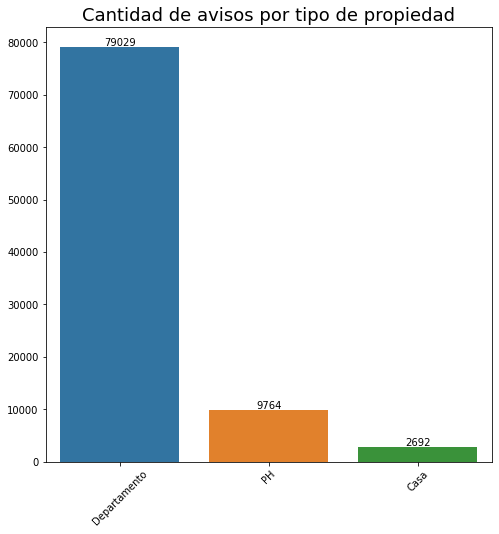

In [11]:
plt.figure(figsize=(8,8))
grafico = sns.countplot(x = "property_type", data = datos, order = datos["property_type"].value_counts().index)

plt.title("Cantidad de avisos por tipo de propiedad", fontsize=18)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("")

conteo = list(datos.property_type.value_counts())
for rect, label in zip(grafico.patches, conteo):
    height = rect.get_height()
    grafico.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')

plt.show()

Es decir que los **avisos de departamentos son los más frecuentes.**

## 1.1 Detección y tratamiento de valores faltantes

La cantidad de valores faltantes por cada columna es la siguiente:

In [12]:
datos.isnull().sum(axis = 0)

rooms                 0
bedrooms              0
bathrooms          2171
surface_total      8917
surface_covered    9235
price                 0
property_type         0
dtype: int64

Es decir que existen **2.171 avisos sin cantidad de baños, 8.917 sin superficie total y 9.235 sin dato de superficie cubierta**, es decir que la proporción de faltantes en el caso de esta última variable es más del 10% del total.

Para determinar el tratamiento de estos valores se debe determinar que comporamiento obedecen:
1. **MCAR:** Los valores faltantes se comportan de forma totalmente aleatoria.
2. **MAR:** Los valores faltantes no dependen de la variable objetivo pero si de alguna otra variable.
3. **MNAR:** Los valores faltantes dependen de la variable objetivo.

Para poder encontrar algún tipo de patrón más facilmente se procede a dividir la variable precio en 50 intervalos con igual cantidad de observaciones:

In [13]:
datos_f = datos.copy()
datos_f['price_intervalos'] = pd.qcut(datos.price, q  = 90)
datos_f.head(5)

rooms  bedrooms  bathrooms  ...     price  property_type      price_intervalos
0    7.0       7.0        2.0  ...  153000.0   Departamento  (152000.0, 155000.0]
1    2.0       1.0        2.0  ...  159000.0             PH  (158000.0, 160000.0]
2    2.0       1.0        1.0  ...  125000.0             PH  (123452.4, 125000.0]
3    2.0       1.0        1.0  ...  295000.0             PH  (289000.0, 295000.0]
5    2.0       1.0        1.0  ...  150000.0             PH  (148000.0, 150000.0]

[5 rows x 8 columns]

La primera variable con valores faltantes que se analiza es la **cantidad de baños**

In [14]:
datos_fb = datos_f.bathrooms.isnull().groupby(datos_f['price_intervalos']).sum().astype(int).reset_index(name='conteo')
datos_fb['frecuencia'] = datos_fb['conteo']/datos_f.groupby([datos_f['price_intervalos']]).count()['price'].values
datos_fb["centros"] = datos_fb["price_intervalos"].apply(lambda x: x.mid)
datos_fb = datos_fb.drop(datos_fb.index[89])

Cabe destacar que se eliminó el último segmento para realizar el siguiente gráfico dado que dificultaba la visualización:

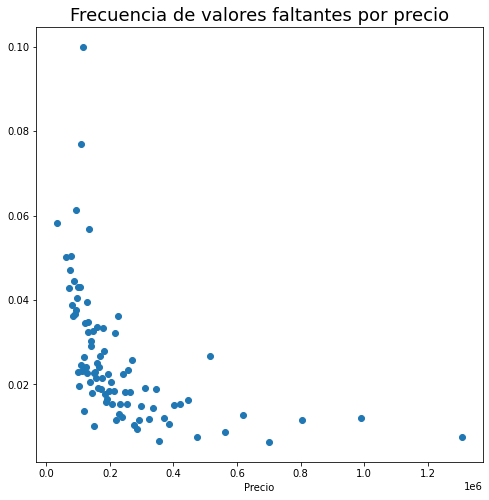

In [15]:
plt.figure(figsize=(8,8))

plt.title("Frecuencia de valores faltantes por precio", fontsize=18)
plt.scatter(datos_fb['centros'], datos_fb['frecuencia'])
plt.xlabel('Precio')
plt.show()

De acuerdo al gráfico previo **los valores faltantes no se distribuyen de forma aleatoria (MNAR)** dado que en los primeros dos deciles la frecuenia de valores faltantes es mayor a la del resto. Es por este motivo por el cual recurrir a reemplazar los mismos por estimadores como la media o la mediana de todas las observaciones resulta incorrecto.

Para tener alguna intuición respecto a que otra variable puede servir para rellenar los valores faltantes se procede a realizar un mapa de correlación:

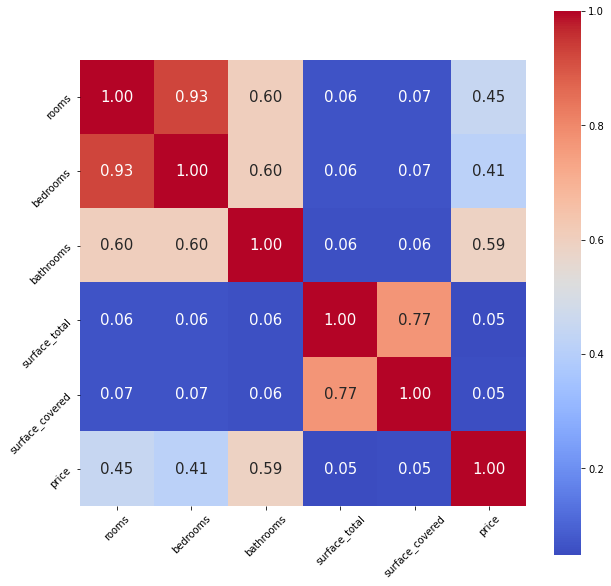

In [16]:
corr = datos.drop('property_type', 1).corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15}, 
            xticklabels= datos.drop('property_type', 1).columns, 
            yticklabels= datos.drop('property_type', 1).columns, 
            cmap= "coolwarm")
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)

plt.show()

**La variable más correlacionada con la cantidad de baños es la cantidad de habitaciones**. Es decir que la estadística va de la mano de la intuición: a mayor cantidad de ambientes mayor es la cantidad de baños.

Para reemplazar los valores faltantes se va a tomar el promedio de baños de avisos con igual cantidad de habitaciones e imputar dicho valor a los faltantes.

In [17]:
datos.bathrooms = datos.groupby("rooms")["bathrooms"].apply(lambda x: x.fillna(x.mean()))
datos.bathrooms = datos.bathrooms.round(0)

Antes de analizar los valores faltantes de superficie total y superficie
cubierta es necesario saber si existe una inconsistencia entre estos dos valores en los avisos. Lo que se esta buscando es **identificar los avisos en los que la superficie cubierta supera a la superficie total.**

In [18]:
np.sum(datos.surface_covered > datos.surface_total)

760

**Hay 760 avisos en los que la superficie cubierta supera la superficie total.** En todos estos casos se reemplaza la superficie cubierta cubierta por la superficie total.

In [19]:
datos.loc[datos.surface_covered > datos.surface_total, "surface_covered"] = datos.loc[datos.surface_covered > datos.surface_total, "surface_total"]

A continuación se realiza el mismo analísis para la variable **superficie total**:

In [20]:
datos_fb = datos_f.surface_total.isnull().groupby(datos_f['price_intervalos']).sum().astype(int).reset_index(name='conteo')
datos_fb['frecuencia'] = datos_fb['conteo']/datos_f.groupby([datos_f['price_intervalos']]).count()['price'].values
datos_fb["centros"] = datos_fb["price_intervalos"].apply(lambda x: x.mid)
datos_fb = datos_fb.drop(datos_fb.index[89])

Se procede a gráficar la relación entre valores faltantes y precio:

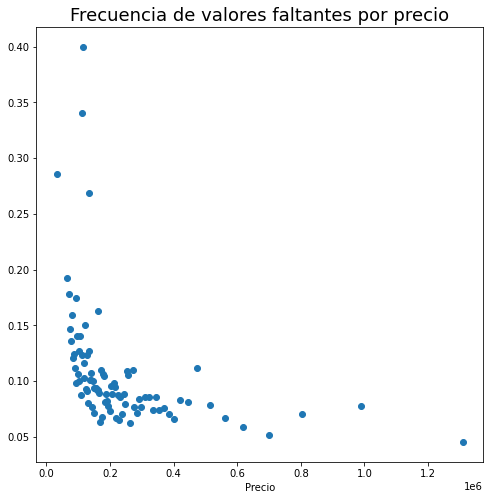

In [21]:
plt.figure(figsize=(8,8))

plt.title("Frecuencia de valores faltantes por precio", fontsize=18)
plt.scatter(datos_fb['centros'], datos_fb['frecuencia'])
plt.xlabel('Precio')
plt.show()

Como en el caso anterior existe una relación entre los valores faltantes y la variable objetivo, es decir se trata nuevamente de un **caso de MNAR**.

De acuerdo al mapa de correlaciones mostrado anteriormente pareciera que **la única variable con la que existe una correlación es superficie cubierta**, la cual también tiene un número importante de faltantes. Sin embargo es **muy probable que esto sea el resultado de la existencia de valores extremos** (o outliers) los cuales serán analizados en la siguiente sección. Lo previamente mencionado se puede observar en un boxplot:

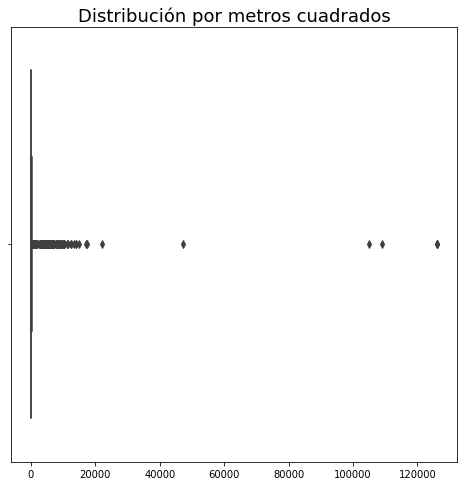

In [22]:
plt.figure(figsize=(8,8))
grafico = sns.boxplot(x=datos["surface_total"])

plt.title("Distribución por metros cuadrados", fontsize=18)
plt.xlabel("")
plt.ylabel("")

plt.show()

Se puede apreciar claramente como **la existencia de valores extremos no permite distinguir el boxplot** dentro del cual se encuentran en 75% de las observaciones. Por lo previamente mencionado, y para poder distinguir mejor la correlación entre las variables, **se volverá a calcular el mapa de correlaciones pero solo teniendo en cuenta los avisos hasta el percentil 99 en la distribución de superficie total.**

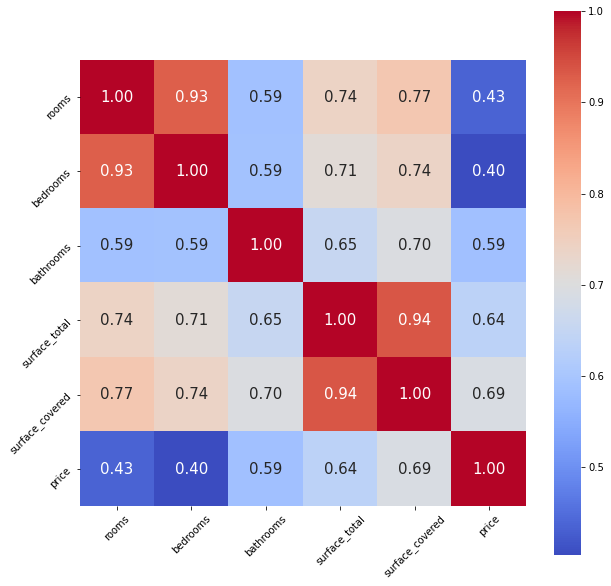

In [23]:
datos_s = datos.copy()
datos_s=datos_s.loc[(datos_s.surface_total <= datos_s.surface_total.quantile(0.99))]
corr = datos_s.drop('property_type', 1).corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15}, 
            xticklabels= datos_s.drop('property_type', 1).columns, 
            yticklabels= datos_s.drop('property_type', 1).columns, 
            cmap= "coolwarm")
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)

plt.show()

Del nuevo mapa de correlaciones se concluye que la superficie total se relaciona con la cantidad de ambientes. Se procede a reemplazar los valores faltantes de superficie total de acuerdo al numero de ambientes:

In [24]:
datos.surface_total= datos.groupby("rooms")["surface_total"].apply(lambda x: x.fillna(x.mean()))

La única variable que faltaría tratar es la de **superficie cubierta**. Se procede a analizar si existe una relación entre el dato faltante y la variable objetivo:

In [25]:
datos_fb = datos_f.surface_covered.isnull().groupby(datos_f['price_intervalos']).sum().astype(int).reset_index(name='conteo')
datos_fb['frecuencia'] = datos_fb['conteo']/datos_f.groupby([datos_f['price_intervalos']]).count()['price'].values
datos_fb["centros"] = datos_fb["price_intervalos"].apply(lambda x: x.mid)
datos_fb = datos_fb.drop(datos_fb.index[89])

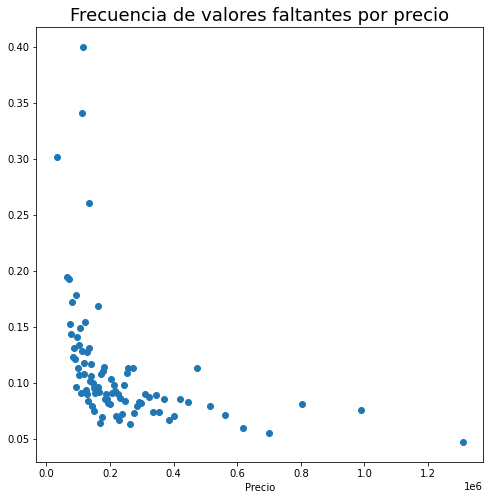

In [26]:
plt.figure(figsize=(8,8))

plt.title("Frecuencia de valores faltantes por precio", fontsize=18)
plt.scatter(datos_fb['centros'], datos_fb['frecuencia'])
plt.xlabel('Precio')
plt.show()

Como en el caso de las variables anteriores **se trata de un caso de MNAR** motivo por el cual se procede a reemplazar los valores faltantes de acuerdo a la variable con la que existe una importante correlacion (cantidad de habitaciones):

In [27]:
datos.surface_covered= datos.groupby("rooms")["surface_covered"].apply(lambda x: x.fillna(x.mean()))

Con esto se concluye el tratamiendo de valores faltantes:

In [28]:
datos.isnull().sum(axis = 0)

rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
property_type      0
dtype: int64

## 1.2 Detección y eliminación de outliers

De acuerdo a lo mostrado en la sección anterior y aplicando el método `describe` se puede apreciar claramente la existencia de valores atípicos:

In [29]:
datos.describe()

rooms      bedrooms  ...  surface_covered         price
count  91485.000000  91485.000000  ...     91485.000000  9.148500e+04
mean       2.964278      1.960278  ...        91.047177  2.595003e+05
std        1.314704      1.072946  ...       725.927203  3.222654e+05
min        1.000000      0.000000  ...         1.000000  6.000000e+03
25%        2.000000      1.000000  ...        44.653317  1.200000e+05
50%        3.000000      2.000000  ...        63.000000  1.750000e+05
75%        4.000000      3.000000  ...        95.000000  2.790000e+05
max       26.000000     15.000000  ...    126062.000000  3.243423e+07

[8 rows x 6 columns]

Por ejemplo, la variable superficie total tiene una mediana de 84 y el 75% de los avisos son de propiedades de menos de 165 metros cuadrados, sin embargo el valor máximo es de 126.062 metros cuadrados.

La existencia de outliers puede llevar a que se modifiquen las conclusiones obtenidas de los modelos: un claro ejemplo es el que se vio en la sección anterior en la que en la primera matriz de correlaciones no existía relación lineal entre superficie total y superficie cubierta, sin embargo al eliminar los valores extremos la relación apareció.

Para el presente analísis se considera que **el mejor camino es la eliminación de valores extremos dado que se esta buscando un modelo que aplique para la mayoria de los avisos** y que los resultados no se vean alterados por casos particulares.

In [30]:
datos.loc[datos.surface_covered > datos.surface_total, "surface_covered"] = datos.loc[datos.surface_covered > datos.surface_total, "surface_total"]

**La primera variable a ser tratada es la superficie total**. Se realiza el boxplot y el histograma:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


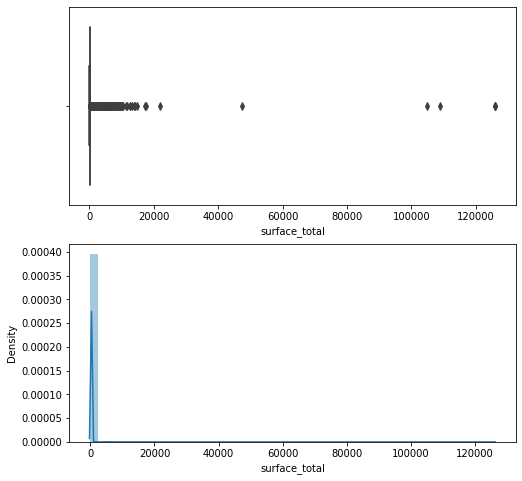

In [31]:
plt.figure(figsize=(8,8))

plt.subplot(2,1,1)
sns.boxplot(datos["surface_total"])

plt.subplot(2,1,2)
sns.distplot(datos["surface_total"])

plt.show()

El hecho que no se pueda visualizar el boxplot es señal que existen valores extremos. Los dos criterios para eliminar los mismos son:
1. **Regla de las tres sigmas (o desviaciones estandar).**
2. **Rango intercuartilico**

El criterio a utilizar es el segundo dado que para el cálculo de la regla de las tres sigmas se utilizan la media y la desviación estándar, dos estadísticos sensibles a los valores extremos.

A continuación se calcula el rango intercuartílico y se procede a eliminar los valores extremos:

In [32]:
q25 = datos.surface_total.quantile(0.25)
q75 = datos.surface_total.quantile(0.75)
iqr = q75 - q25
print(q25,q75,iqr)

51.0 110.0 59.0


In [33]:
datos = datos.loc[(datos.surface_total <= q75 + iqr * 1.5) & (datos.surface_total >= q25 - iqr * 1.5)]

Con los valores extremos eliminados la distribución pasa a ser la siguiente:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


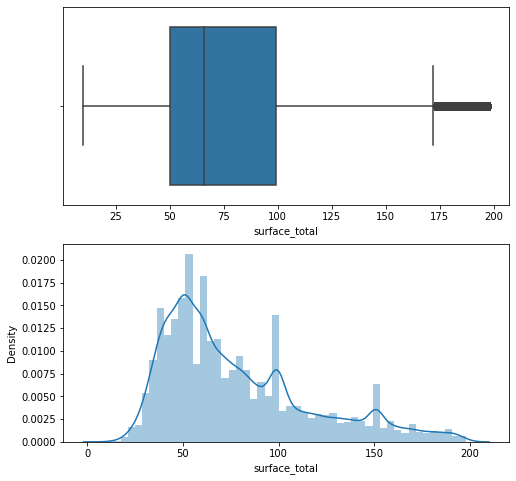

In [34]:
plt.figure(figsize=(8,8))

plt.subplot(2,1,1)
sns.boxplot(datos["surface_total"])

plt.subplot(2,1,2)
sns.distplot(datos["surface_total"])

plt.show()

Dado que se puso la condición que la superficie cubierta no puede superar la superficie total no existe necesidad de realizar el mismo procedimiento para la primera.

La variable siguiente a tratar es **precio**, cuya distribución es la siguiente:

In [35]:
plt.figure(figsize=(8,8))

plt.subplot(2,1,1)
sns.boxplot(datos["price"])

plt.subplot(2,1,2)
sns.distplot(datos["price"])

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Se procede a realizar el mismo procedimiento para eliminar los valores extremos:

In [36]:
q25 = datos.price.quantile(0.25)
q75 = datos.price.quantile(0.75)
iqr = q75 - q25
print(q25,q75,iqr)

118800.0 250000.0 131200.0


In [37]:
datos = datos.loc[(datos.price <= q75 + iqr * 1.5) & (datos.price >= q25 - iqr * 1.5)]

El resultado es el siguiente:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


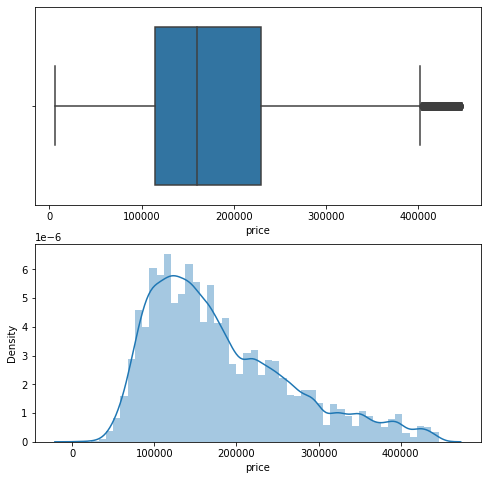

In [38]:
plt.figure(figsize=(8,8))

plt.subplot(2,1,1)
sns.boxplot(datos["price"])

plt.subplot(2,1,2)
sns.distplot(datos["price"])

plt.show()

En la salida del método `describe` se puede observar claramente la existencia de valore extremos para las variables rooms, bedrooms y bathrooms. Para estas variables se utilizará el mismo criterio que en las anteriores:

In [39]:
q25 = datos.rooms.quantile(0.25)
q75 = datos.rooms.quantile(0.75)
iqr = q75 - q25
datos = datos.loc[(datos.rooms <= q75 + iqr * 1.5) & (datos.rooms >= q25 - iqr * 1.5)]

q25 = datos.bedrooms.quantile(0.25)
q75 = datos.bedrooms.quantile(0.75)
iqr = q75 - q25
datos = datos.loc[(datos.bedrooms <= q75 + iqr * 1.5) & (datos.bedrooms >= q25 - iqr * 1.5)]

q25 = datos.bathrooms.quantile(0.25)
q75 = datos.bathrooms.quantile(0.75)
iqr = q75 - q25
datos = datos.loc[(datos.bathrooms <= q75 + iqr * 1.5) & (datos.bathrooms >= q25 - iqr * 1.5)]

Luego de completar este analísis el resultado es el siguiente:

In [40]:
datos.describe()

rooms      bedrooms  ...  surface_covered          price
count  75493.000000  75493.000000  ...     75493.000000   75493.000000
mean       2.587843      1.665479  ...        61.847902  175562.387387
std        0.909358      0.786702  ...        26.157098   82549.793806
min        1.000000      0.000000  ...         1.000000    7500.000000
25%        2.000000      1.000000  ...        43.000000  114000.000000
50%        3.000000      2.000000  ...        55.000000  156000.000000
75%        3.000000      2.000000  ...        77.000000  220000.000000
max        4.000000      3.000000  ...       194.000000  446000.000000

[8 rows x 6 columns]

## 1.3 Escalado

En el dataset se tienen variables expresadas en distintas unidades de medida: las columnas rooms, bedrooms y bathrooms en unidades, surface_total y surface_covered en metros cuadrados y price en dólares. Para que estas variables sean comparables entre si, y para que los modelos de ML puedan capturar mejor sus relaciones e impacto, se procede a realizar una estandarización.

In [41]:
for columna in datos:
  if pd.api.types.is_numeric_dtype(datos[columna]):
    media = datos[columna].mean()
    desviacion = datos[columna].std()
    datos[columna] = (datos[columna] - media)/desviacion

## 1.4 Encoding

La columna tipo de propiedad es de tipo categorico con lo cual para poder incluir esta información en el analísis es necesario realizar un encoding:

In [42]:
datos = pd.get_dummies(datos,drop_first=True, columns=['property_type'])

En el código anterior lo que se hizo fue crear variables dummies de acuerdo a los tipos de propiedad.

## 1.5 Modelos simples y comparación con resultados del Proyecto 1

Lo primero que se hace es definir las variables:

In [43]:
x1 = datos["rooms"]
x2 = datos["bedrooms"]
x3 = datos["bathrooms"]
x4 = datos["surface_total"]
x5 = datos["surface_covered"]
x6 = datos["property_type_Departamento"]
x7 = datos["property_type_PH"]
y = datos["price"]

Se separan los datos para hacer el entrenamiento y la prueba:

In [44]:
X = np.vstack((x1,x2,x3,x4,x5,x6,x7)).T

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Se utilizarán las siguientes métricas para evaluar los desempeño de los modelos: 

1. **Coeficiente de determinacion (o R cuadrado):** mide que proporción de la variabilidad de la variable independiente es explicada por el modelo. Asume un valor entre 0 (lo que indica que el modelo no predice nada de la variabilidad) a 1 (lo que indica que el modelo predice prefectamente la variabilidad de la variable independiente).
2. **RMSE**: mide el cuadrado de la desviación entre las observaciones (valor real) y el valor predicho por el modelo. El valor más bajo que puede asumir es 0 (lo que indicaría que el modelo se ajusta perfectamente a los datos).

**Se van a buscar modelos que maximicen el R2 y minimicen el RMSE**.

Se comienza con el **árbol de decisión**:

In [45]:
lista_r2_train = []
lista_r2_test = []

depth = [1,5,10,15,20,25,30]

for m in depth:
  arbol = DecisionTreeRegressor(max_depth=m)
  arbol.fit(X_train, y_train)
  y_train_pred = arbol.predict(X_train)
  train_r2 = r2_score(y_train, y_train_pred)
  y_test_pred = arbol.predict(X_test) 
  test_r2 = r2_score(y_test, y_test_pred) 
  lista_r2_train.append(train_r2) 
  lista_r2_test.append(test_r2)

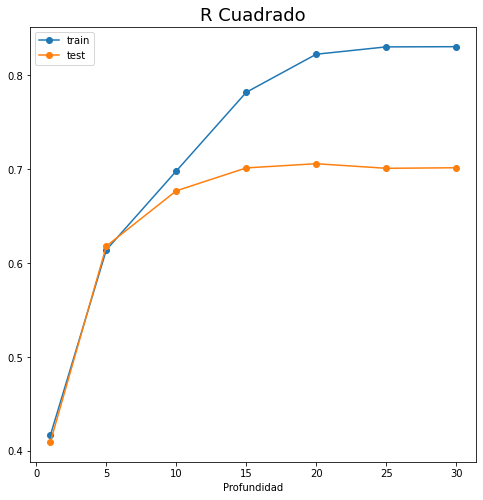

In [46]:
plt.figure(figsize = (8,8))

plt.title("R Cuadrado", fontsize=18)
plt.plot(depth, lista_r2_train,'o-',label='train' )
plt.plot(depth, lista_r2_test,'o-',label='test')
plt.legend()
plt.xlabel("Profundidad")
plt.ylabel("")

plt.show()

Del gráfico anterior se puede concluir que a partir de la profunidad 20 no hay mejoras en el poder predictivo del modelo motivo por el cual se selecciona esta profundiad como "óptima".

In [47]:
arbol = DecisionTreeRegressor(max_depth=20)
arbol.fit(X_train, y_train)
y_train_pred = arbol.predict(X_train)
y_test_pred = arbol.predict(X_test)

rmse_train_arbol = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_arbol = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_arbol=r2_score(y_test, y_test_pred)

print("El r cuadrado del arbol es: " + str(r2_arbol))
print("La raíz del error cuadrático medio en Train es: " + str(rmse_train_arbol))
print("La raíz del error cuadrático medio en Test es: " + str(rmse_test_arbol))

El r cuadrado del arbol es: 0.7049857129690651
La raíz del error cuadrático medio en Train es: 0.42095585473244057
La raíz del error cuadrático medio en Test es: 0.5437043558801322


Se procede a realizar el mismo analísis con el **modelo KNN**:

In [48]:
lista_r2_train = []
lista_r2_test = []

k_vecinos = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] 

for k in k_vecinos: 
  knr = KNeighborsRegressor(n_neighbors=k)
  knr.fit(X_train, y_train)
  y_train_pred = knr.predict(X_train) 
  train_r2 = r2_score(y_train, y_train_pred) 
  y_test_pred = knr.predict(X_test) 
  test_r2 = r2_score(y_test, y_test_pred)
  lista_r2_train.append(train_r2)
  lista_r2_test.append(test_r2)

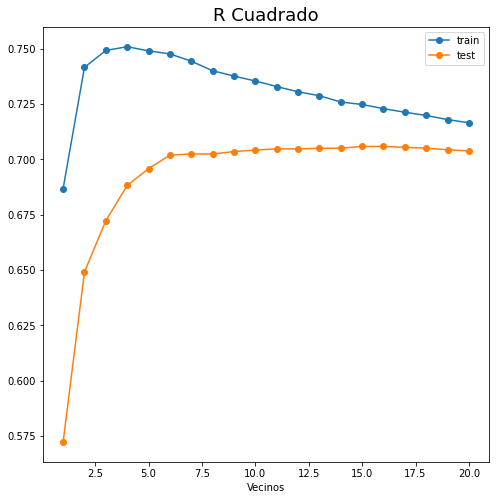

In [49]:
plt.figure(figsize = (8,8))

plt.title("R Cuadrado", fontsize=18)
plt.plot(k_vecinos, lista_r2_train,'o-',label='train')
plt.plot(k_vecinos, lista_r2_test,'o-',label='test')
plt.legend()
plt.xlabel("Vecinos")
plt.ylabel("")

plt.show()

Dado que a partir de los 6 vecinos parece no haber ganancias importantes en términos de poder de predicción se va a tomar este número de vecinos.

In [50]:
knr = KNeighborsRegressor(n_neighbors=6)
knr.fit(X_train, y_train)
y_train_pred = knr.predict(X_train)
y_test_pred = knr.predict(X_test)

rmse_train_knr = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_knr = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_knr=r2_score(y_test, y_test_pred)

print("El r cuadrado del modelo es: " + str(r2_knr))
print("La raíz del error cuadrático medio en Train es: " + str(rmse_train_knr))
print("La raíz del error cuadrático medio en Test es: " + str(rmse_test_knr))

El r cuadrado del modelo es: 0.7018532330779891
La raíz del error cuadrático medio en Train es: 0.5021846162114898
La raíz del error cuadrático medio en Test es: 0.5465832771070556


Por último se realiza **la regresión lineal**. El modelo de regresión lineal supone que no existe relación lineal entre las variables explicativas, es por ello que se calcula el mapa de correlaciones para descartar las variables que esten correlacionadas:

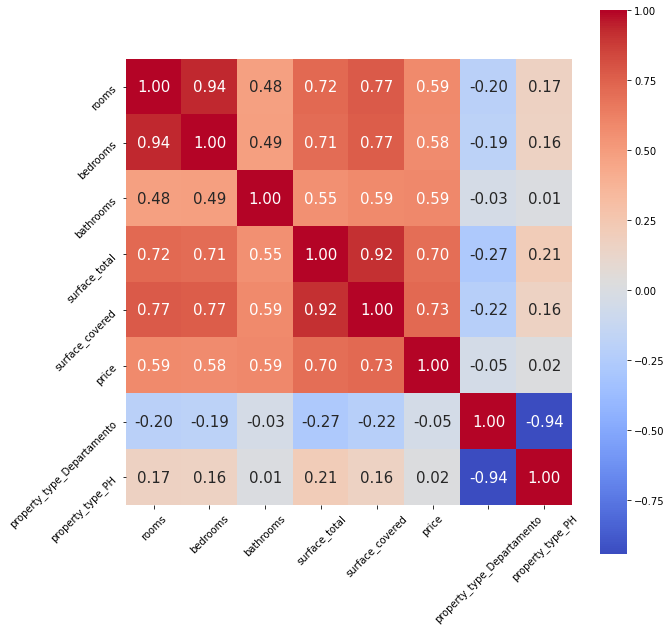

In [51]:
corr = datos.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15}, 
            xticklabels= datos.columns, 
            yticklabels= datos.columns, 
            cmap= "coolwarm")
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)

plt.show()

De acuerdo a la intuición y a los resultados obtenidos en el mapa de correlaciones anterior existe una relación lineal entre todas las variables proporcionadas (en todos los casos la correlación supera el 0,5), motivo por el cual **solo se van a utilizar la superficie total y las dummies como variables independientes.**

In [52]:
X = np.vstack((x4,x6,x7)).T

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [53]:
modelo_lineal = LinearRegression()
modelo_lineal.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [54]:
y_train_pred = modelo_lineal.predict(X_train)
y_test_pred = modelo_lineal.predict(X_test)

rmse_train_regresion = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_regresion = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_regresion=r2_score(y_test, y_test_pred)

print("El R cuadrado del modelo de regresión lineal es " + str(r2_regresion))
print("La raíz del error cuadrático medio en Train es: " + str(rmse_train_regresion))
print("La raíz del error cuadrático medio en Test es: " + str(rmse_test_regresion))

El R cuadrado del modelo de regresión lineal es 0.5213907657952048
La raíz del error cuadrático medio en Train es: 0.6966643218777786
La raíz del error cuadrático medio en Test es: 0.6925192098449627


Con los tres modelos entrenados se crea un dataframe para comparar los resultados obtenidos en los modelos del proyecto 1 con los del proyecto 2:

In [55]:
resultados = {"Modelo": ["Arboles de decisión", "KNN", "Regresión lineal"], "R2 Proyecto 1": [0.722776, 0.713687, 0.476958], "R2 Proyecto 2": [r2_arbol, r2_knr, r2_regresion]}
resultados = pd.DataFrame(data=resultados)

resultados

Modelo  R2 Proyecto 1  R2 Proyecto 2
0  Arboles de decisión       0.722776       0.704986
1                  KNN       0.713687       0.701853
2     Regresión lineal       0.476958       0.521391

Los R cuadrados indican que en el caso del arból de decisión y el KNN los cambios realizados en las variables tuvieron un leve efecto negativo en el poder predictivo de los modelos, mientras que en el caso del modelo de regresión lineal se obtuvo una mejora.

Cabe destacar que no se realizó la comparación de los RMSE con los modelos del proyecto anterior dado que los datos se encuentran en distinta escala y por ende no resultan comparables.

# 2. Modelos Avanzados

## 2.1. Modelo de regresión con atributos polinómicos

En este tipo de modelos el hiperparametro a seleccionar es el grado del polinomio, motivo por el cual se va a realizar un analísis similar al que se realizó para los modelos de KNN (con el número de vecinos) y arboles de decisión (con la profundidad).

In [ ]:
X = np.vstack((x4,x6,x7)).T
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

lista_r2_train = []
lista_r2_test = []

potencias = np.arange(1,25,1)

for potencia in potencias:

  poly = PolynomialFeatures(degree = potencia ,include_bias=False)
  modelo_reg_poly = LinearRegression()

  X_train_poly = poly.fit_transform(X_train)
  X_test_poly = poly.fit_transform(X_test)
  modelo_reg_poly.fit(X_train_poly, y_train)

  y_train_pred = modelo_reg_poly.predict(X_train_poly)
  y_test_pred = modelo_reg_poly.predict(X_test_poly)

  train_r2 = r2_score(y_train, y_train_pred)
  test_r2 = r2_score(y_test, y_test_pred)

  lista_r2_train.append(train_r2) 
  lista_r2_test.append(test_r2)

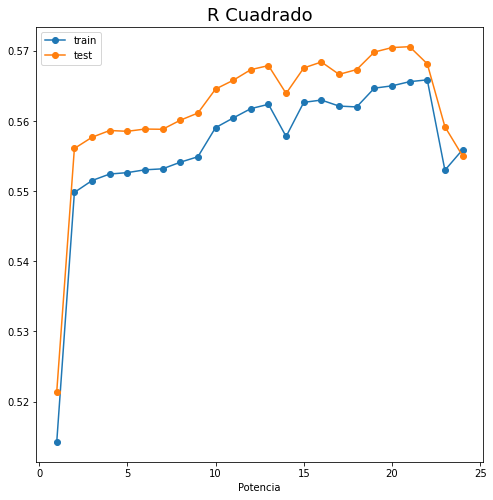

In [ ]:
plt.figure(figsize = (8,8))

plt.title("R Cuadrado", fontsize=18)
plt.plot(potencias, lista_r2_train,'o-',label='train' )
plt.plot(potencias, lista_r2_test,'o-',label='test')
plt.legend()
plt.xlabel("Potencia")
plt.ylabel("")

plt.show()

De acuerdo al gráfico anterior el **óptimo exponente es 22**. No obstante **es muy probable que dado que se trata de un exponente alto el modelo cuente con una alta varianza respecto a otros con menor grado de exponente**.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

poly = PolynomialFeatures(degree = 22 ,include_bias=False)
modelo_reg_poly = LinearRegression()

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
modelo_reg_poly.fit(X_train_poly, y_train)

y_train_pred = modelo_reg_poly.predict(X_train_poly)
y_test_pred = modelo_reg_poly.predict(X_test_poly)

rmse_train_reg_poly = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_reg_poly = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_reg_poly=r2_score(y_test, y_test_pred)

print("El R cuadrado del modelo de regresión lineal con atributos polinómicos es " + str(r2_reg_poly))
print("La raíz del error cuadrático medio en Train es: " + str(rmse_train_reg_poly))
print("La raíz del error cuadrático medio en Test es: " + str(rmse_test_reg_poly))

El R cuadrado del modelo de regresión lineal con atributos polinómicos es 0.568190092099488
La raíz del error cuadrático medio en Train es: 0.658565958174738
La raíz del error cuadrático medio en Test es: 0.6577904887563466


## 2.2 Modelos de ensamble

El próximo modelo a desarrollar es un **Random Forest**, un modelo de Bootstrap Aggregation (o bagging).

In [ ]:
X = np.vstack((x1,x2,x3,x4,x5,x6,x7)).T

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
lista_r2_train = []
lista_r2_test = []

depth = [1,5,10,15,20,25,30]

for m in depth:
  bosque = RandomForestRegressor(max_depth=m)
  bosque.fit(X_train, y_train)
  y_train_pred = bosque.predict(X_train)
  train_r2 = r2_score(y_train, y_train_pred)
  y_test_pred = bosque.predict(X_test) 
  test_r2 = r2_score(y_test, y_test_pred) 
  lista_r2_train.append(train_r2) 
  lista_r2_test.append(test_r2)

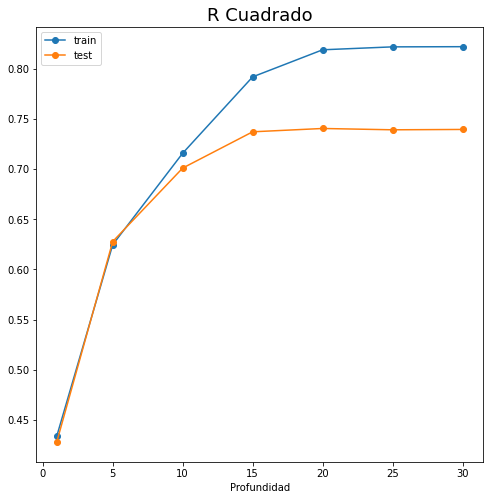

In [ ]:
plt.figure(figsize = (8,8))

plt.title("R Cuadrado", fontsize=18)
plt.plot(depth, lista_r2_train,'o-',label='train' )
plt.plot(depth, lista_r2_test,'o-',label='test')
plt.legend()
plt.xlabel("Profundidad")
plt.ylabel("")

plt.show()

A partir de una profunidad de 15 no hay ganancias importantes en términos de poder de predicción del modelo, motivo por el cual se va a tomar este valor.

In [ ]:
bosque = RandomForestRegressor(max_depth=15)
bosque.fit(X_train, y_train)
y_train_pred = bosque.predict(X_train)
y_test_pred = bosque.predict(X_test)

rmse_train_bosque = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_bosque = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_bosque=r2_score(y_test, y_test_pred)

print("El r cuadrado del bosque es: " + str(r2_bosque))
print("La raíz del error cuadrático medio en Train es: " + str(rmse_train_bosque))
print("La raíz del error cuadrático medio en Test es: " + str(rmse_test_bosque))

El r cuadrado del bosque es: 0.7368396214481114
La raíz del error cuadrático medio en Train es: 0.4558257287080734
La raíz del error cuadrático medio en Test es: 0.5135131143222097


El otro modelo de ensamble a desarrollar es el **XGBoost**, un modelo de boosting.

In [ ]:
lista_r2_train = []
lista_r2_test = []

depth = [1,5,8,9,10,11,12,13,15]

for d in depth:
  XGBR = xgb.XGBRegressor(max_depth=d, silent = True)
  XGBR.fit(X_train, y_train)
  y_train_pred = XGBR.predict(X_train)
  train_r2 = r2_score(y_train, y_train_pred)
  y_test_pred = XGBR.predict(X_test) 
  test_r2 = r2_score(y_test, y_test_pred) 
  lista_r2_train.append(train_r2) 
  lista_r2_test.append(test_r2)

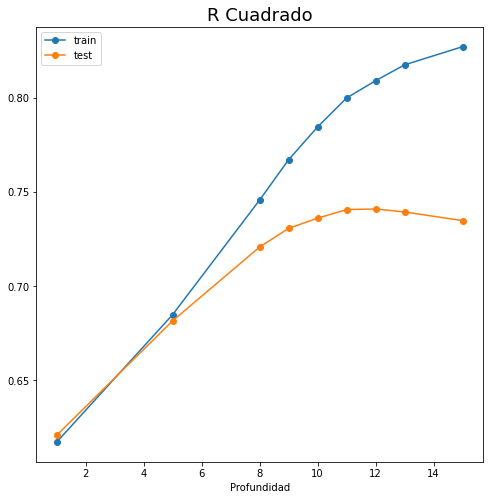

In [ ]:
plt.figure(figsize = (8,8))

plt.title("R Cuadrado", fontsize=18)
plt.plot(depth, lista_r2_train,'o-',label='train' )
plt.plot(depth, lista_r2_test,'o-',label='test')
plt.legend()
plt.xlabel("Profundidad")
plt.ylabel("")

plt.show()

El número de profunidad que maximiza la predictibilidad del modelo es 11.

In [ ]:
XGBR = xgb.XGBRegressor(max_depth=11)
XGBR.fit(X_train, y_train)
y_train_pred = XGBR.predict(X_train)
y_test_pred = XGBR.predict(X_test)

rmse_train_XGBR = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_XGBR = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_XGBR=r2_score(y_test, y_test_pred)

print("El r cuadrado del XG Boost es: " + str(r2_XGBR))
print("La raíz del error cuadrático medio en Train es: " + str(rmse_train_XGBR))
print("La raíz del error cuadrático medio en Test es: " + str(rmse_test_XGBR))

[12:18:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
El r cuadrado del XG Boost es: 0.7407120841399792
La raíz del error cuadrático medio en Train es: 0.4470179402156833
La raíz del error cuadrático medio en Test es: 0.5097208826829435


## 2.3 Optimización de hiperparámetros

Los resultados obtenidos en las secciones anteriores se presentan en el siguiente cuadro en donde se muestran dos medidas para visualizar el poder predictivo de los modelos:
1. **R2**: mide que proporción de la variabilidad de la variable independiente es explicada por el modelo. Asume un valor entre 0 (lo que indica que el modelo no predice nada de la variabilidad) a 1 (lo que indica que el modelo predice prefectamente la variabilidad de la variable independiente).
2. **RMSE**: mide el cuadrado de la desviación entre las observaciones (valor real) y el valor predicho por el modelo. El valor más bajo que puede asumir es 0 (lo que indicaría que el modelo se ajusta perfectamente a los datos).

Con la información de la tabla se procede a seleccionar 3 modelos para realizar la optimización de hiperparámetros.


In [ ]:
resultados = {"Modelo": ["Arboles de decisión", "KNR", "Regresión lineal", "Regresión lineal con atributos polinomicos", "Random Forest", "XGBoost"],
              "R2 Proyecto 2": [r2_arbol, r2_knr, r2_regresion, r2_reg_poly, r2_bosque, r2_XGBR],
              "RMSE Proyecto 2": [rmse_test_arbol, rmse_test_knr, rmse_test_regresion, rmse_test_reg_poly, rmse_test_bosque, rmse_test_XGBR]}
resultados = pd.DataFrame(data=resultados)

resultados

Modelo  R2 Proyecto 2  RMSE Proyecto 2
0                         Arboles de decisión       0.704569         0.544088
1                                         KNR       0.701853         0.546583
2                            Regresión lineal       0.521391         0.692519
3  Regresión lineal con atributos polinomicos       0.568190         0.657790
4                               Random Forest       0.736840         0.513513
5                                     XGBoost       0.740712         0.509721

Los modelos que muestran tener un mayor poder predictivo son:
1. XGBoost
2. Random Forest
3. Arboles de decisión

**El primer modelo a optimizar es el XGBoost** y el hiperparámetro en este caso es la profunidad. La optimización se realiza a través de validación cruzada.

In [ ]:
XGBR_train_scores_mean = []
XGBR_train_scores_std = []
XGBR_test_scores_mean = []
XGBR_test_scores_std = []

profundidades = np.arange(1,15,1)

for profundidad in profundidades:
    XGBR = xgb.XGBRegressor(max_depth=profundidad)
    XGBR_scores = cross_validate(XGBR, X, y, cv=5, scoring ='r2', return_train_score=True, n_jobs = -1)
    
    XGBR_train_scores_mean.append(XGBR_scores['train_score'].mean())
    XGBR_train_scores_std.append(XGBR_scores['train_score'].std())
    
    XGBR_test_scores_mean.append(XGBR_scores['test_score'].mean())
    XGBR_test_scores_std.append(XGBR_scores['test_score'].std())

XGBR_train_scores_mean = np.array(XGBR_train_scores_mean)
XGBR_train_scores_std = np.array(XGBR_train_scores_std)
XGBR_test_scores_mean = np.array(XGBR_test_scores_mean)
XGBR_test_scores_std = np.array(XGBR_test_scores_std)

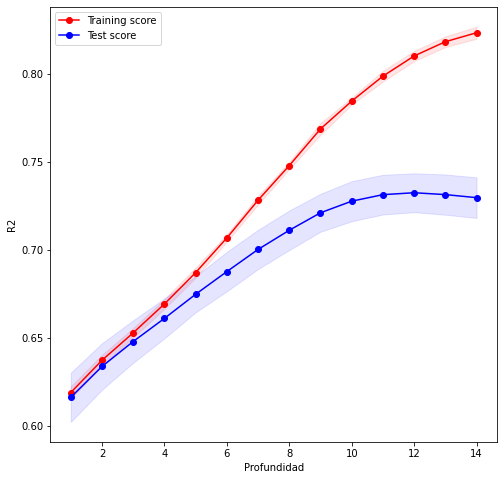

In [ ]:
plt.figure(figsize=(8,8))
plt.fill_between(profundidades, XGBR_train_scores_mean - XGBR_train_scores_std,
                 XGBR_train_scores_mean + XGBR_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, XGBR_test_scores_mean - XGBR_test_scores_std,
                 XGBR_test_scores_mean + XGBR_test_scores_std, alpha=0.1, color="b")
plt.plot(profundidades, XGBR_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, XGBR_test_scores_mean, 'o-', color="b",
         label="Test score")
plt.legend()
plt.ylabel('R2')
plt.xlabel('Profundidad')
plt.show()

Dado que no existe una diferencia importante en la varianza **se confirma la conclusión obtenido anteriormente, la profunidad óptima es 11.**

Para **Random Forest** se realiza el mismo analísis:

In [ ]:
RFR_train_scores_mean = []
RFR_train_scores_std = []
RFR_test_scores_mean = []
RFR_test_scores_std = []

profundidades = np.arange(1,20,1)

for profundidad in profundidades:
    RFR = RandomForestRegressor(max_depth=profundidad)
    RFR_scores = cross_validate(RFR, X, y, cv=5, scoring ='r2', return_train_score=True, n_jobs = -1)
    
    RFR_train_scores_mean.append(RFR_scores['train_score'].mean())
    RFR_train_scores_std.append(RFR_scores['train_score'].std())
    
    RFR_test_scores_mean.append(RFR_scores['test_score'].mean())
    RFR_test_scores_std.append(RFR_scores['test_score'].std())

RFR_train_scores_mean = np.array(RFR_train_scores_mean)
RFR_train_scores_std = np.array(RFR_train_scores_std)
RFR_test_scores_mean = np.array(RFR_test_scores_mean)
RFR_test_scores_std = np.array(RFR_test_scores_std)

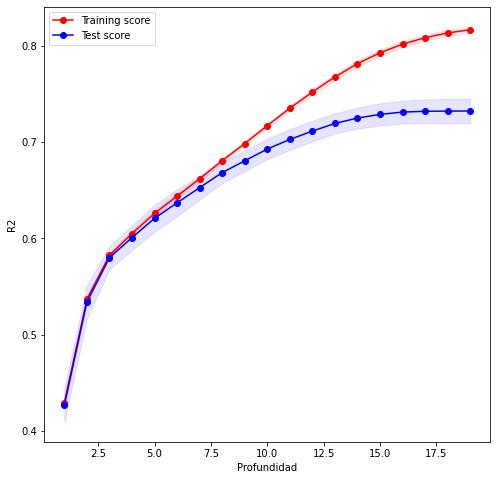

In [ ]:
plt.figure(figsize=(8,8))
plt.fill_between(profundidades, RFR_train_scores_mean - RFR_train_scores_std,
                 RFR_train_scores_mean + RFR_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, RFR_test_scores_mean - RFR_test_scores_std,
                 RFR_test_scores_mean + RFR_test_scores_std, alpha=0.1, color="b")
plt.plot(profundidades, RFR_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, RFR_test_scores_mean, 'o-', color="b",
         label="Test score")
plt.legend()
plt.ylabel('R2')
plt.xlabel('Profundidad')
plt.show()

Al igual que en el caso anterior la validación cruzada no nos aporta información nueva.

Por último se trabaja con **árboles de decisión**:

In [ ]:
Arbol_train_scores_mean = []
Arbol_train_scores_std = []
Arbol_test_scores_mean = []
Arbol_test_scores_std = []

profundidades = np.arange(1,20,1)

for profundidad in profundidades:
    Arbol = DecisionTreeRegressor(max_depth=profundidad)
    Arbol_scores = cross_validate(Arbol, X, y, cv=5, scoring ='r2', return_train_score=True, n_jobs = -1)
    
    Arbol_train_scores_mean.append(Arbol_scores['train_score'].mean())
    Arbol_train_scores_std.append(Arbol_scores['train_score'].std())
    
    Arbol_test_scores_mean.append(Arbol_scores['test_score'].mean())
    Arbol_test_scores_std.append(Arbol_scores['test_score'].std())

Arbol_train_scores_mean = np.array(Arbol_train_scores_mean)
Arbol_train_scores_std = np.array(Arbol_train_scores_std)
Arbol_test_scores_mean = np.array(Arbol_test_scores_mean)
Arbol_test_scores_std = np.array(Arbol_test_scores_std)

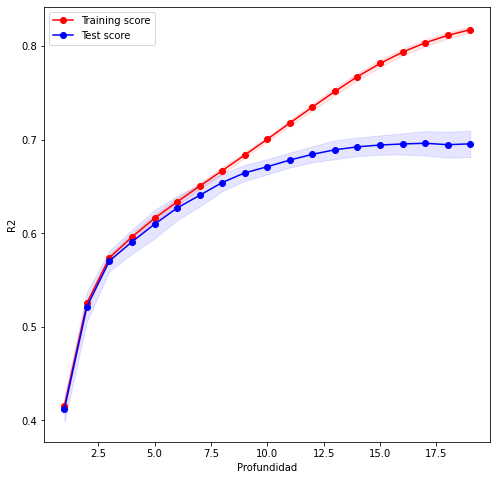

In [ ]:
plt.figure(figsize=(8,8))
plt.fill_between(profundidades, Arbol_train_scores_mean - Arbol_train_scores_std,
                 Arbol_train_scores_mean + Arbol_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, Arbol_test_scores_mean - Arbol_test_scores_std,
                 Arbol_test_scores_mean + Arbol_test_scores_std, alpha=0.1, color="b")
plt.plot(profundidades, Arbol_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, Arbol_test_scores_mean, 'o-', color="b",
         label="Test score")
plt.legend()
plt.ylabel('R2')
plt.xlabel('Profundidad')
plt.show()

Ocurre lo mismo que en los otros dos modelos, es decir que la validación cruzada sobre un solo hiperparámetro no aporta información adicional relevante.

**Hasta ahora se estuvo realizando una optimización solo sobre un hiperparámetro** aunque todos los modelos seleccionados tienen varios hiperparámetros que se pueden modificar. **Para poder seleccionar entre la mejor combinación entre hiperparámetros se tiene dos métodos**:
1. **Grid Search**: prueba con todas las combinaciones posibles de hiperparámetros. La ventaja de este método es clara: se prueban todas las combinaciones, sin embargo el tener que calcular tantos modelos lleva que sea muy exigente desde el punto de vista computacional.
2. **Random Search**: en vez de entrenar los modelos con todas las combinaciones posibles solo lo hace con una selección aleatoria. La ventaja es que no es tan exigente a nivel computacional.

Dado que los modelos se ensamble de por si son exigente a nivel computacional para estos se aplicara un Random Search mientras que el Grid Search se aplicará en el caso del arbol de decisión.

Para mejorar la **optimización se utilizará GridSearch para el modelo XGBoost**. Los hiperparámetros a optimizar son los siguientes:
1. **Max_depth**: determina la profunidad del árbol y asume valores a partir de 1.
2. **Min_child_weight**: especifica la suma mínima de ponderación de instancia (hessiana) necesaria en un hijo. Mientras más alto sea el valor más conservador es el algoritmo.
3. **Gamma**: hiperparámetro de regularización que asume valores entre 0 (no hay regularización) e infinito, aunque se considera que un valor de 20 es extremo.

In [ ]:
param_distributions = {"max_depth": np.arange(1, 26,1),
              "min_child_weight": np.arange(1,10,1),
              "gamma": np.arange(0,0.5,0.1)}
scoring = 'r2'

In [ ]:
xgbr = xgb.XGBRegressor(seed=0)
random_xgbr = RandomizedSearchCV(estimator=xgbr, param_distributions=param_distributions, n_jobs=-1, cv=4, scoring=scoring)

In [ ]:
random_xgbr.fit(X_train, y_train)

[12:33:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                                          seed=0, silent=None, subsample=1,
                                          verbosity=1),
                   iid='deprecated', n_iter=10, n_jobs=-

El mejor modelo es el siguiente:

In [ ]:
print(random_xgbr.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.2,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=14, min_child_weight=7, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
             subsample=1, verbosity=1)


Los parámetros del modelo son los siguientes:

In [ ]:
print(random_xgbr.best_params_)

{'min_child_weight': 7, 'max_depth': 14, 'gamma': 0.2}


In [ ]:
y_train_pred = random_xgbr.predict(X_train)
y_test_pred = random_xgbr.predict(X_test)

Los resultados son los siguientes:

In [ ]:
train_r2_random_xgbr = r2_score(y_train,y_train_pred)
test_r2_random_xgbr = r2_score(y_test,y_test_pred)
rmse_test_random_xgbr = np.sqrt(mean_squared_error(y_train,y_train_pred))
rmse_train_random_xgbr = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("El R cuadrado en train es: " + str(train_r2_random_xgbr))
print("El R cuadrado en test es: " + str(test_r2_random_xgbr))
print("La raíz del error cuadrático medio en train es: " + str(rmse_train_random_xgbr))
print("La raíz del error cuadrático medio en test es: " + str(rmse_test_random_xgbr))

El R cuadrado en train es: 0.7883829623177806
El R cuadrado en test es: 0.7359773612929494
La raíz del error cuadrático medio en train es: 0.5143537039902908
La raíz del error cuadrático medio en test es: 0.45981351088061395


A continuación se realiza el mismo proceso pero para el **Random Forest**. Los hiperparámetros a optimizar son los siguientes:
1. **Max_depth**: determina la profunidad del árbol y asume valores a partir de 1.
2. **Min_sample_split**: el número mínimo de observaciones en un nodo para que haya un split. El valor por default es 2, es decir que cada vez que haya nodos con más de 2 observaciones no similares el árbol hace un split. Valores altos llevan a que no haya splits y por ende que los árboles no diferencien entre observaciones distintas.
3. **max_features**: determina el número máximo de parámetros. El valor por default es la raíz cuadrada de los features originales.
4. **n_estimators**: determina el número de árboles. Puede ir de 1 a infinito, aunque valores más grandes llevan a mayores necesidades de procesamiento que no necesariamente significan mayor poder de predicción.

In [ ]:
param_distributions = {
    "max_depth": np.arange(1,31,1),
    "min_samples_split": np.arange(6,21,2),
    "max_features": np.arange(2,13,1),
    "n_estimators": np.arange(100,1100,100)
}
scoring = 'r2'

In [ ]:
rfr = RandomForestRegressor()
random_rfr = RandomizedSearchCV(estimator = rfr, param_distributions=param_distributions, cv = 4, n_jobs = -1, scoring=scoring)

In [ ]:
random_rfr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

De acuerdo al analísis anterior el mejor modelo es el siguiente:

In [ ]:
print(random_rfr.best_estimator_)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=22, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      n_estimators=800, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


Siendo los mejores parámetros los que aparecen en la salida del siguiente código:

In [ ]:
print(random_rfr.best_params_)

{'n_estimators': 800, 'min_samples_split': 6, 'max_features': 4, 'max_depth': 22}


In [ ]:
y_train_pred = random_rfr.predict(X_train)
y_test_pred = random_rfr.predict(X_test)

Los resultados son los siguientes:

In [ ]:
train_r2_random_rfr = r2_score(y_train,y_train_pred)
test_r2_random_rfr = r2_score(y_test,y_test_pred)
rmse_test_random_rfr = np.sqrt(mean_squared_error(y_train,y_train_pred))
rmse_train_random_rfr = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("El R cuadrado en train es: " + str(train_r2_random_rfr))
print("El R cuadrado en test es: " + str(test_r2_random_rfr))
print("La raíz del error cuadrático medio en train es: " + str(rmse_test_random_rfr))
print("La raíz del error cuadrático medio en test es: " + str(rmse_train_random_rfr))

El R cuadrado en train es: 0.8062501779973192
El R cuadrado en test es: 0.7427335461752894
La raíz del error cuadrático medio en train es: 0.4399740568090963
La raíz del error cuadrático medio en test es: 0.5077300503242961


Por último se buscara **optimizar los hiperparámetros de un arbol de decisión mediante Grid Search**. Los hiperparámetros a optimizar son los siguientes:
1. **Max_depth**: al igual que en los modelos anteriores indica la profunidad del árbol. Asume valores entre 1 e infinito.
2. **min_samples_leaf**: regula el número mínimo de observaciones que tienen que haber en un nodo para que éste pueda ser considerado un nodo externo o leaf. El valor mínimo es 1, aunque cabe destacar que valores bajos llevan a árboles más complejos y por ende es más posible que haya overfitting.
3. **min_samples_split**: determina el número mínimo de observaciones que tienen que haber en un nodo para que éste pueda hacer un split. El valor mínimo es 1 y al igual que con min_samples_leaf valores bajos llevan a riesgo de overfitting.
4. **max_features**: el número máximo de features considerados a la hora de hacer splits, puede ir de 1 al máximo de splits.

In [ ]:
param_grid = {
    "max_depth": np.arange(1,31,1),
    "min_samples_split": np.arange(2,10,1),
    "max_features": np.arange(2,8,1),
    "min_samples_leaf": np.arange(2,10,1)
}
scoring = 'r2'

In [ ]:
arbol = DecisionTreeRegressor()
grid_arbol = GridSearchCV(estimator = arbol, param_grid = param_grid, scoring = scoring, cv = 4)

In [ ]:
grid_arbol.fit(X_train, y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26,

El mejor modelo es el siguiente:

In [ ]:
print(grid_arbol.best_estimator_)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=21,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=7, min_samples_split=9,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')


In [ ]:
print(grid_arbol.best_params_)

{'max_depth': 21, 'max_features': 6, 'min_samples_leaf': 7, 'min_samples_split': 9}


Los resultados obtenidos son los siguientes:

In [ ]:
y_train_pred = grid_arbol.predict(X_train)
y_test_pred = grid_arbol.predict(X_test)

In [ ]:
train_r2_grid_arbol = r2_score(y_train,y_train_pred)
test_r2_grid_arbol = r2_score(y_test,y_test_pred)
rmse_test_grid_arbol = np.sqrt(mean_squared_error(y_train,y_train_pred))
rmse_train_grid_arbol = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("El R cuadrado en train es: " + str(train_r2_grid_arbol))
print("El R cuadrado en test es: " + str(test_r2_grid_arbol))
print("La raíz del error cuadrático medio en train es: " + str(rmse_test_grid_arbol))
print("La raíz del error cuadrático medio en test es: " + str(rmse_train_grid_arbol))

El R cuadrado en train es: 0.7577402228902629
El R cuadrado en test es: 0.7110804476916321
La raíz del error cuadrático medio en train es: 0.49197957105247603
La raíz del error cuadrático medio en test es: 0.5380588197648323


Los resultados de las optimizaciones anteriores se resumen en la siguiente tabla en la que se comparan los valores obtenidos con los de la optimización anterior en la que solo se modificaba un hiperparámetro:


In [ ]:
resultados = {"Modelo": ["Arboles de decisión", "Random Forest", "XGBoost"],
              "R2 (sin optimización)": [r2_arbol, r2_bosque, r2_XGBR],
              "RMSE (sin optimización)": [rmse_test_arbol, rmse_test_bosque, rmse_test_XGBR],
              "R2 (optimizado)": [test_r2_grid_arbol, test_r2_random_rfr, test_r2_random_xgbr],
              "RMSE (optimizado)": [rmse_test_grid_arbol, rmse_test_random_rfr, rmse_test_random_xgbr],
              }
resultados = pd.DataFrame(data=resultados)

resultados

Modelo  ...  RMSE (optimizado)
0  Arboles de decisión  ...           0.491980
1        Random Forest  ...           0.439974
2              XGBoost  ...           0.459814

[3 rows x 5 columns]

De acuerdo a la tabla anterior el **mejor modelo es el Random Forest** dado que es el que tiene el mayor R cuadrado y menor RMSE.

# 3. Conclusiones

Con el modelo ya seleccionado y los hiperparámetros óptimos se procede a determinar cuales fueron los features más importantes a la hora de determinar el precio de la propiedad:

In [ ]:
rfr = RandomForestRegressor(n_estimators = 800, min_samples_split =  6, max_features = 4, max_depth = 22)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=22, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      n_estimators=800, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
importancia = rfr.feature_importances_
columns = datos.drop(columns=["price"]).columns
indices = np.argsort(importancia)[::-1]

plt.figure(figsize = (8,8))
sns.barplot(columns[indices], importancia[indices])
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Es decir que de acuerdo a lo esperado y a lo obtenido en el proyecto anterior la superfice (tanto toal como cubierta) son los principales factores que explican el nivel de precios de una propiedad.

Las conclusiones son las siguientes:
1. La utilización de modelos más complejos permitió una leve mejora en el poder predictivo de los modelos.
2. La optimización de hiperparámetros mediante grid search y random search mejoró los resultados obtenidos.
3. La superficie es el principal determinante del precio de una propiedad.

No obstante es necesario destacar que:
1. La falta de poder computacional derivó en que para los modelos más complejos no fuese conveniente realizar grid search, es decir que los resultados obtenidos puede que no sean los óptimos.

# 4. Clustering

En esta sección se va a trabajar con dos técnicas de clustering:
1. **K-means**
2. **DBSCAN**

La idea es encontrar patrones entre los avisos en base al dataset disponible. **Para simplificar la visualización se va a reducir el número de dimensiones a 2 a través de PCA**.

Lo primero que se realiza es reducir la dimensión de los features a 2:

In [56]:
x1 = datos["rooms"]
x2 = datos["bedrooms"]
x3 = datos["bathrooms"]
x4 = datos["surface_total"]
x5 = datos["surface_covered"]
x6 = datos["property_type_Departamento"]
x7 = datos["property_type_PH"]
y = datos["price"]

X = np.vstack((x1,x2,x3,x4,x5,x6,x7)).T

In [57]:
pca = PCA(n_components=2)
X_nuevo = pca.fit_transform(X) 

Dado que hay solo dos dimensiones se puede graficar el resultado obtenido:

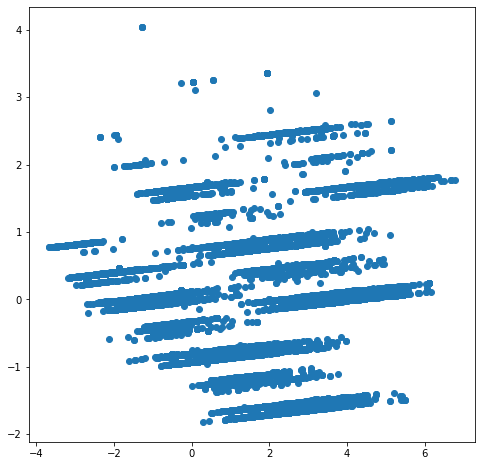

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(X_nuevo[:,0], X_nuevo[:,1])
plt.show()

## 2.1 K-means

El primer algortimo de clustering a aplicar es K-means. La ventaja que ofrece este modelo es su rapidez y que el único hiperparámetro es la cantidad de clusters. Las principales desventajas son que solo funciona con clusters redondos (en el caso de dos dimensiones) y que es sensible a outliers.

**Para determinar el número óptimo de clusters se utiliza el metodo de Silhouette**. Este método calcula un indicador para cada punto, el indicador asume un valor entre 1 y -1: se acerca a 1 cuanto más parecido sea al punto al resto del propio cluster y más distinto sea al resto y se va acercando a -1 cuando sucede lo opuesto.

In [ ]:
lista_sil = []

for k in range(2,20):
    km = KMeans(n_clusters=k)
    km = km.fit(X_nuevo)

    etiquetas = km.labels_

    valor_medio_sil = silhouette_score(X_nuevo, etiquetas)
    lista_sil.append(valor_medio_sil)

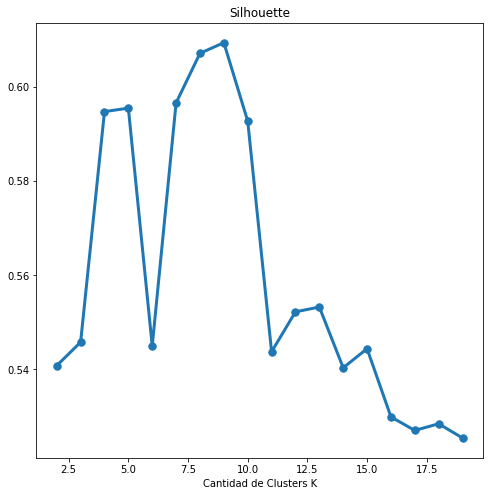

In [ ]:
K = np.arange(2,20)

plt.figure(figsize = (8,8))
plt.plot(K, lista_sil, lw=3)
plt.scatter(K, lista_sil,s=55)
plt.xlabel('Cantidad de Clusters K')
plt.title("Silhouette")

plt.show()

Del gráfico anterior se obtiene que el número óptimo de clusters es 9.

In [ ]:
km = KMeans(n_clusters=9)
labels = km.fit_predict(X_nuevo)
centroids = km.cluster_centers_

silhouette_vals = silhouette_samples(X_nuevo, labels)

In [ ]:
plt.figure(figsize = (8,8))
y_lower, y_upper = 0, 0
for i, cluster in enumerate(np.unique(labels)):
 cluster_silhouette_vals = silhouette_vals[labels == cluster]
 cluster_silhouette_vals.sort()
 y_upper += len(cluster_silhouette_vals)
 plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
 plt.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
 y_lower += len(cluster_silhouette_vals)

avg_score = np.mean(silhouette_vals)

plt.axvline(avg_score, linestyle='--', linewidth=2, color='green')
plt.xlim([-0.1, 1])
plt.xlabel('Coeficientes Silhouette')
plt.title('Silhouette plot', y=1.02)

plt.show()

En el siguiente gráfico se observan los 6 clusters junto con sus centros:

In [ ]:
plt.figure(figsize = (8,8))
plt.scatter(X_nuevo[:, 0], X_nuevo[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
plt.show()

Queda claro que el algoritmo utilizado no resulta el más conveniente dada la forma que tienen los datos.

## 2.2 DB SCAN

El segundo algoritmo de clustering es el DB SCAN. Las ventajas que ofrece este algoritmo es que no hay que elegir el número de parámetros, funciona bien con cualquier forma de clusters y determina automaticamente outliers (el k-means tiene que asignar los puntos a un cluster). Sin embargo hay que determinar bien el valor de los hiperparámetros y es computacionalmente costoso (en términos relativos al K-means).

In [88]:
def plot_DBSCAN(X_nuevo,labels,db,n_clusters):
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X_nuevo[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X_nuevo[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
    plt.title('Número de clusters: %d' % n_clusters)
    plt.show()
    return

In [101]:
db = DBSCAN(eps=0.18, min_samples=16)
db = db.fit(X_nuevo)

labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

In [103]:
plt.figure(figsize = (8,8))
plot_DBSCAN(X_nuevo,labels,db,n_clusters)
plt.show()

In [104]:
valor_medio_sil = silhouette_score(X_nuevo, labels)
print(valor_medio_sil)

0.4334457951427114


El resultado obtenido es peor que el obtenido para K-means (silhouette score de 0,43 con DB SCAN contra más de 0.6). Cabe destacar debido a limitaciones en el poder computacional, tanto de la nube como el de la computadora personal no se pudo realizar un loop para buscar mejorar los valores de los hiperparámetros como se realizó en el caso anterior.